In [1]:
import torch
import umap
import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [3]:
def plot_embeddings(embeddings: torch.tensor, labels:list, title = "plot", method="pca", aggregation="mean"):
    """
    Plot embeddings using PCA or UMAP
    """

    # Create a PCA object
    if method == "umap":
        reducer = umap.UMAP()
    elif method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=5, n_iter=250)
    else:
        raise ValueError("Reducer Method not implemented")

    # Aggregate embeddings along sequence dimension
    if aggregation == "mean":
        embeddings = torch.mean(embeddings, dim=1)
    elif aggregation == "cls":
        embeddings = embeddings[:,0,:]
    else:
        raise ValueError("Aggregation method not implemented")

    # Fit and transform the embeddings using the PCA object
    principalComponents = reducer.fit_transform(embeddings)

    # Create a dataframe with the embeddings and the corresponding labels
    df_embeddings = pd.DataFrame(principalComponents, columns=['x', 'y'])
    df_embeddings['label'] = labels
    
    for label in df_embeddings['label'].unique():
        _df = df_embeddings[df_embeddings['label'] == label]
        plt.scatter(_df['x'], _df['y'], alpha=0.5)
        plt.legend(df_embeddings['label'].unique())

    # Add a title and show the plot
    plt.title(title)

    plt.show()

In [4]:
def summarise_line_label_performance(results_path: str):

    """
    Summarise the performance of a line labelling model on a given dataset split and plot the embeddings. Results dictionary
    should contain embeddings torch.tensor(n_test_samples, seq_length, n_classes), logits torch.tensor(n_test_samples, n_classes) and 
    true OHE labels (n_test_samples, n_classes).

    Args:
        results_path (str): Path to the results of classifier 1. Contains dictionary with embeddings, logits and true OHE labels.

    Returns:
        None 
    """

    # Load dataset
    dataset = torch.load(results_path)
    
    embeddings = dataset["embeddings"]
    logits = dataset["logits"]
    labels = dataset["labels"]
    print("Embeddings shape: ", embeddings.shape)
    print("Predictions shape: ", logits.shape)
    print("Labels shape: ", labels.shape)
    print("Labels example: ", labels[0])
    
    # Import label dict
    import json
    with open(os.path.join(paths.DATA_PATH_PREPROCESSED, "line_labelling/line_labelling_clean_class_mapping.json"), "r") as f:
        label_dict = json.load(f)
        
    # Accuracy
    preds = np.argmax(logits, axis=1)
    labels = np.argmax(labels, axis=1)
    
    # Map labels to class names
    label_names = [label_dict[str(label.item())] for label in labels]

    print(f"Accuracy: {torch.sum(preds == labels) / len(labels)}")
    
    # f1 score, precision, recall
    print(f"F1 Score: {f1_score(labels, preds, average='weighted')}")
    print(f"Precision: {precision_score(labels, preds, average='weighted')}")
    print(f"Recall: {recall_score(labels, preds, average='weighted')}")
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(labels, preds, xticks_rotation=90, display_labels=list(label_dict.values()))
    
    # Plot embeddings PCA
    plt.figure(figsize=(8, 6))
    plot_embeddings(embeddings=embeddings, labels=label_names, method="pca", aggregation="mean")
    
    # Plot embeddings UMAP
    plt.figure(figsize=(8, 6))
    plot_embeddings(embeddings=embeddings, labels=label_names, method="umap", aggregation="mean")

## Medbert Line Label Performance

Embeddings shape:  torch.Size([345, 256, 768])
Predictions shape:  torch.Size([345, 8])
Labels shape:  torch.Size([345, 8])
Labels example:  tensor([1., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
Accuracy: 0.904347836971283
F1 Score: 0.9032833457128908
Precision: 0.9036428949472428
Recall: 0.9043478260869565


<Figure size 800x600 with 0 Axes>

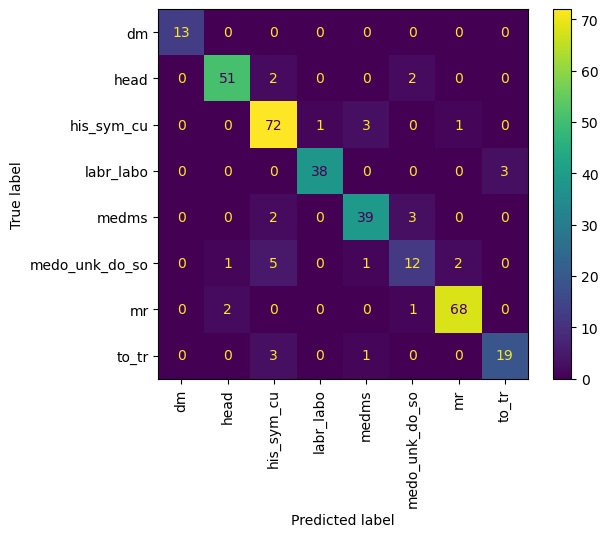

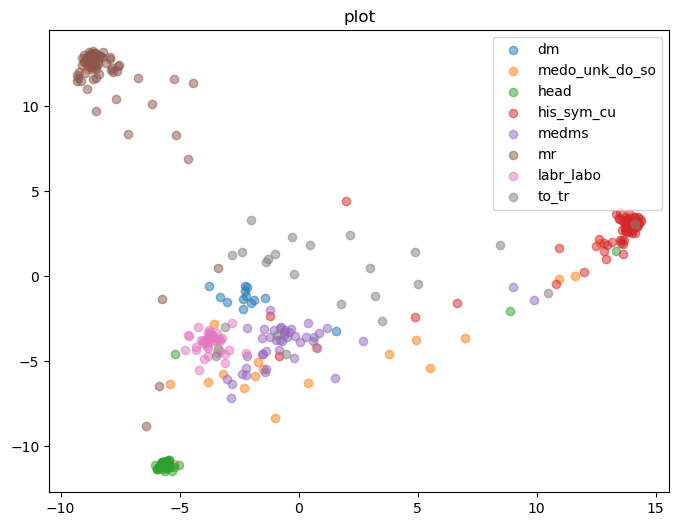

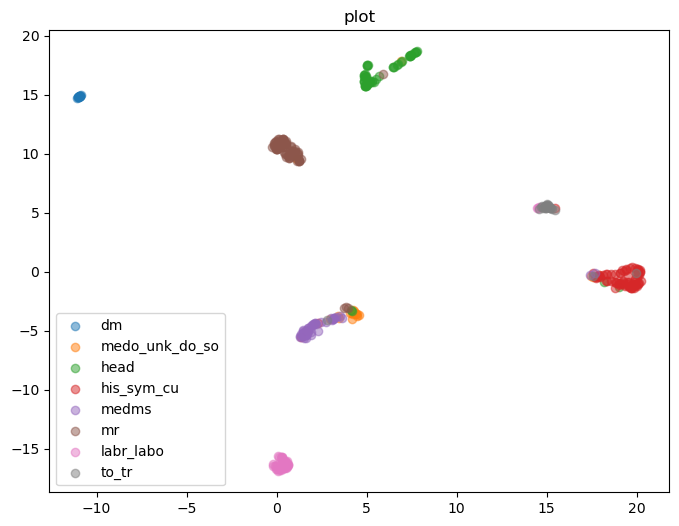

In [11]:
summarise_line_label_performance(paths.RESULTS_PATH/'line_labelling/medBERT-finetuned-test_output.pt')

## Bert Base Multilingual cased Performance

Accuracy: 0.8724637627601624
F1 Score: 0.8707122538839331
Precision: 0.8712538615393891
Recall: 0.8724637681159421


<Figure size 800x600 with 0 Axes>

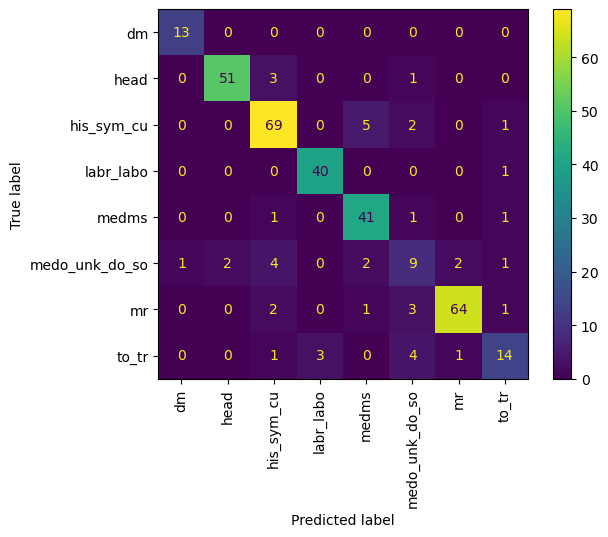

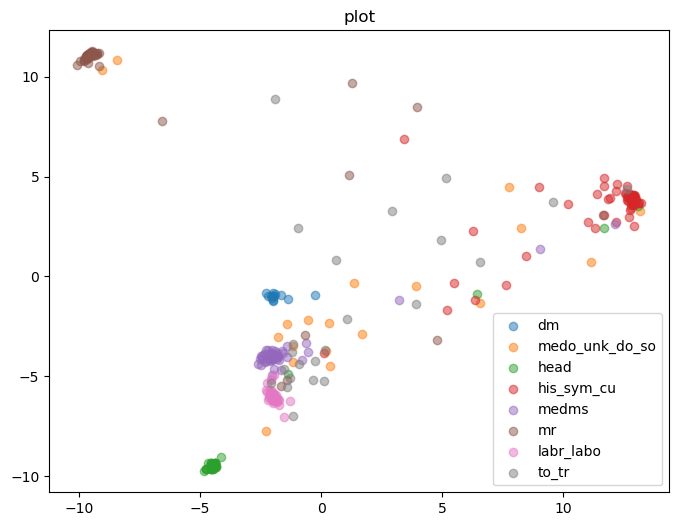

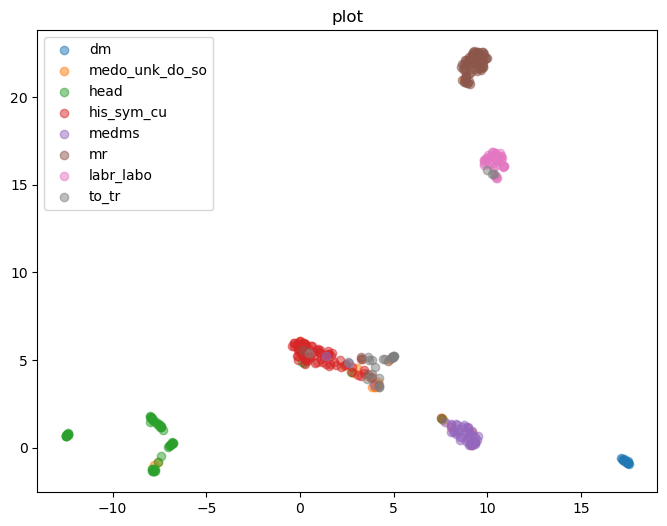

In [31]:
summarise_line_label_performance(paths.RESULTS_PATH/'line_labelling/BERT-multilingual-finetuned-test_output.pt')

## MedBERT Seq2Seq

Embeddings shape:  torch.Size([345, 1, 768])
Predictions shape:  torch.Size([345, 8])
Labels shape:  torch.Size([345, 8])
Labels example:  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
Accuracy: 0.8927536010742188
F1 Score: 0.8882798330940668
Precision: 0.8932473137386505
Recall: 0.8927536231884058


<Figure size 800x600 with 0 Axes>

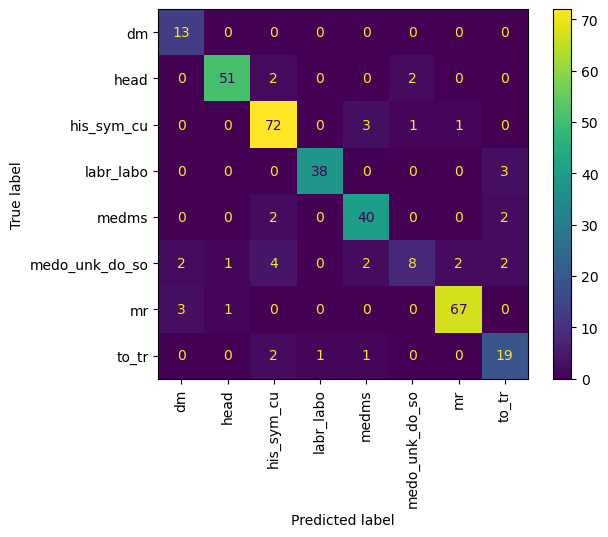

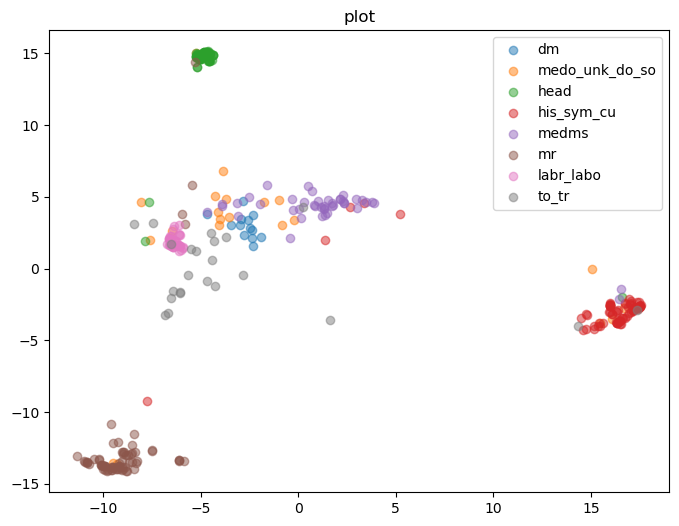

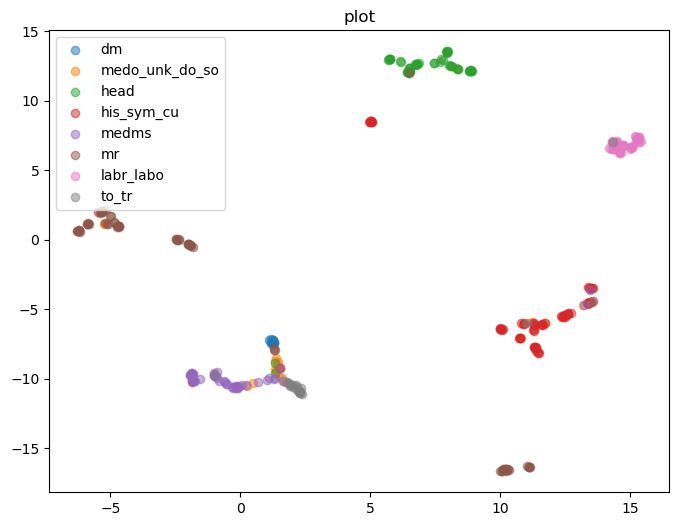

In [4]:
summarise_line_label_performance(paths.RESULTS_PATH/'line_labelling/medbert-token-finetuned-test_output.pt')

## Seq2Seq RoBERTa

Embeddings shape:  torch.Size([345, 1, 1024])
Predictions shape:  torch.Size([345, 8])
Labels shape:  torch.Size([345, 8])
Labels example:  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
Accuracy: 0.9101449251174927
F1 Score: 0.9050464747281498
Precision: 0.9093526108047278
Recall: 0.9101449275362319


<Figure size 800x600 with 0 Axes>

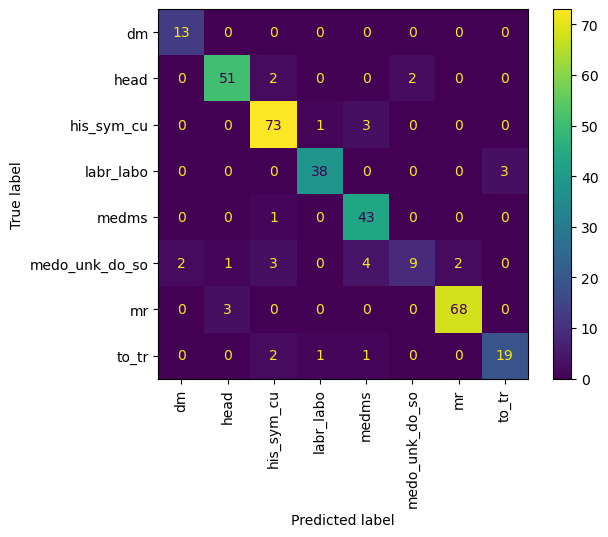

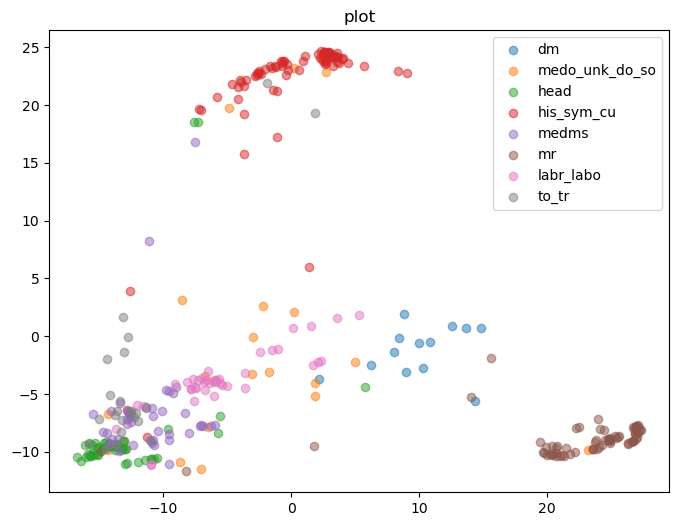

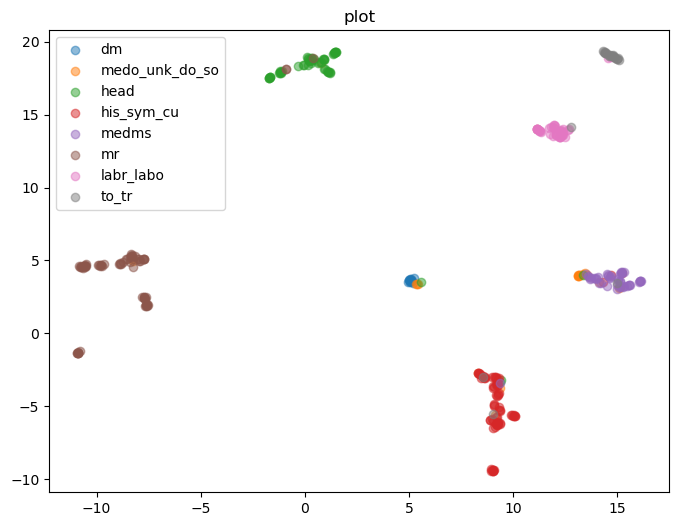

In [6]:
summarise_line_label_performance(paths.RESULTS_PATH/'line_labelling/RoBERTA-seq2seq-finetuned-test-accuracy.pt')

Embeddings shape:  torch.Size([345, 1, 1024])
Predictions shape:  torch.Size([345, 8])
Labels shape:  torch.Size([345, 8])
Labels example:  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
Accuracy: 0.843478262424469
F1 Score: 0.822642400807281
Precision: 0.8399280655043675
Recall: 0.8434782608695652


<Figure size 800x600 with 0 Axes>

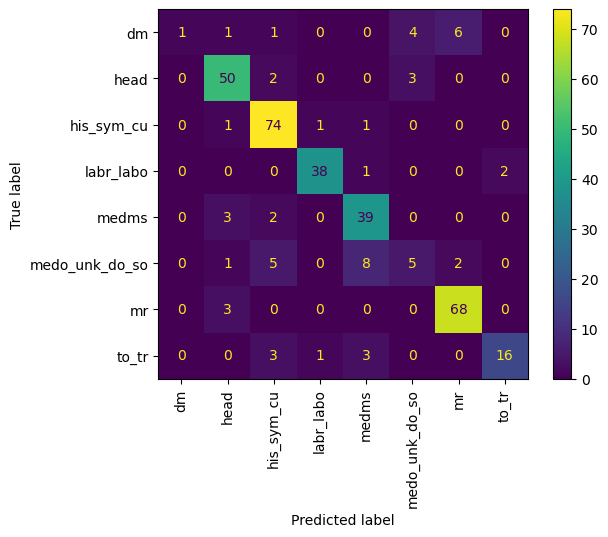

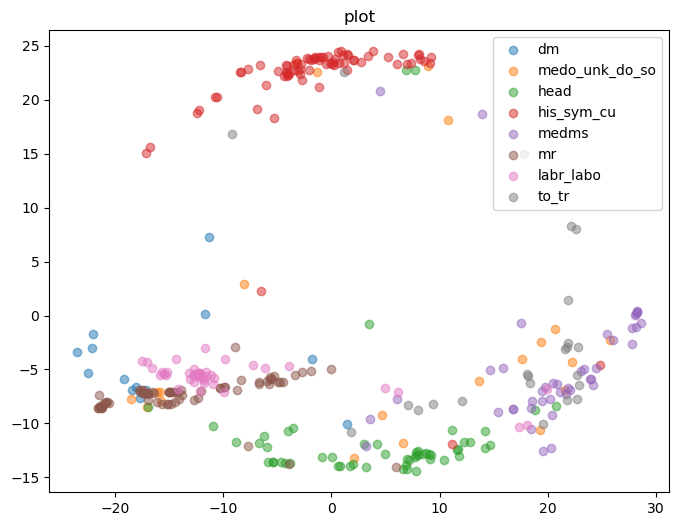

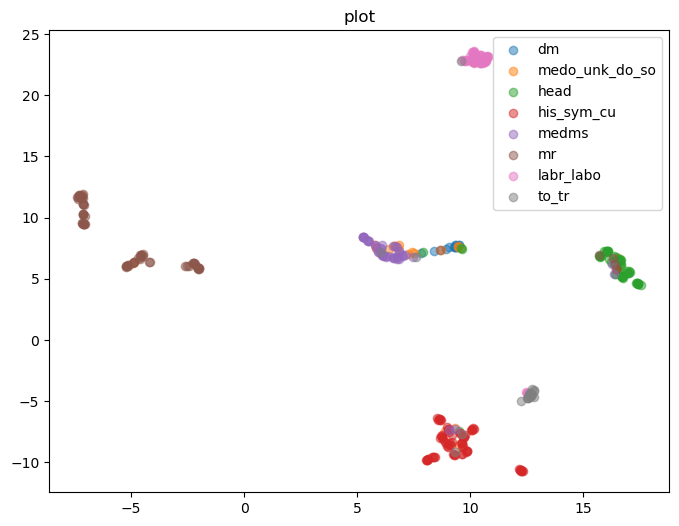

In [7]:
summarise_line_label_performance(paths.RESULTS_PATH/'line_labelling/RoBERTA-seq2seq-finetuned-test-loss.pt')